# Numerical Solvers for Delay Differential Equations

@[Chaoming Wang](https://github.com/chaoming0625)

In real world systems, **delay** is very often encountered in many practical systems, such as automatic control, biology, economics and long transmission lines. The **delayed differential equation (DDEs)** is used to describe these dynamical systems.

Delay differential equations (DDEs) are a type of differential equation in which the derivative at a certain time is given in terms of the values of the function at previous times.

Let's take delay ODEs as the example. The simplest **constant delay** equations have the form

$$
y'(t) = f(t, y(t), y(t-\tau_1), y(t-\tau_2),\ldots, y(t-\tau_k))
$$

where the time delays (lags) $\tau_j$ are positive constants.

For **neutral type DDE** delays appear in derivative terms,

$$
y'(t) = f(t, y(t), y'(t-\tau_1), y'(t-\tau_2),\ldots, y'(t-\tau_k))
$$

More generally, **state dependent** delays may depend on the solution, that is $\tau_i = \tau_i (t,y(t))$.

In BrainPy, we support delay differential equations based on delay variables. Specifically, for state-dependent delays, we have:

- [brainpy.math.TimeDelay](../apis/auto/math/generated/brainpy.math.delay_vars.TimeDelay.rst)
- [brainpy.math.LengthDelay](../apis/auto/math/generated/brainpy.math.delay_vars.LengthDelay.rst)

For neutral-type delays, we use:

- [brainpy.math.NeuTimeDelay](../apis/auto/math/generated/brainpy.math.delay_vars.NeuTimeDelay.rst)
- [brainpy.math.NeuLenDelay](../apis/auto/math/generated/brainpy.math.delay_vars.NeuLenDelay.rst)

In [1]:
import brainpy as bp
import brainpy.math as bm

import matplotlib.pyplot as plt

## Delay variables

For an ODE system, the numerical methods need to know its initial condition $y(t_0)=y_0$ and its derivative rule $y'(t_0) = y'_0$. However, for DDEs, it is not enough to give a set of initial values for the function and its derivatives at $t_0$, but one must give a set of functions to provide the historical values for  $t_0 - max(\tau) \leq t \leq t_0$.

Therefore, you need some delay variables to wrap the variable delays. ``brainpy.math.TimeDelay`` can be used to define delay variables which depend on states, and ``brainpy.math.NeuTimeDelay`` is used to define delay variables which depend on the derivative.

In [2]:
d = bm.TimeDelay(bm.zeros(2), delay_len=10, dt=1, t0=0, before_t0=lambda t: t)

In [3]:
d(0.)

DeviceArray([0., 0.], dtype=float32)

In [4]:
d(-0.5)

DeviceArray([-0.5, -0.5], dtype=float32)

Request a time beyond $(max\_delay, t_0)$ will cause an error.

In [5]:
try:
    d(0.1)
except Exception as e:
    print(e)

ERROR:absl:Outside call <jax.experimental.host_callback._CallbackWrapper object at 0x0000025616D24BE0> threw exception 
!!! Error in TimeDelay: 
The request time should be less than the current time 0. But we got 0.10000000149011612 > 0.



!!! Error in TimeDelay: 
The request time should be less than the current time 0. But we got 0.10000000149011612 > 0


## Delay ODEs

Here we illustrate how to make numerical integration of delay ODEs with several examples. Before that, we define a general function to simulate a delay ODE function.

In [6]:
def delay_odeint(duration, eq, args=None, inits=None,
                 state_delays=None, neutral_delays=None,
                 monitors=('x',), method='euler', dt=0.1):
    # define integrators of ODEs based on `brainpy.odeint`
    dde = bp.odeint(eq,
                    state_delays=state_delays,
                    neutral_delays=neutral_delays,
                    method=method)
    # define IntegratorRunner
    runner = bp.integrators.IntegratorRunner(dde,
                                             args=args,
                                             monitors=monitors,
                                             dt=dt,
                                             inits=inits)
    runner.run(duration)
    return runner.mon

#### Example #1: First-order DDE with one constant delay and a constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t-1)
$$

where the delay is 1 s. the example compares the solutions of three different cases using three different constant history functions:

- Case #1: $\phi(t)=-1$
- Case #2: $\phi(t)=0$
- Cas3 #3: $\phi(t)=1$

In [7]:
def equation(x, t, xdelay):
    return -xdelay(t-1)

case1_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=-1., interp_method='round')
case2_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=0., interp_method='round')
case3_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=1., interp_method='round')

In [8]:
case1 = delay_odeint(20., equation,  args={'xdelay': case1_delay},
                     state_delays={'x': case1_delay}) # delay for variable "x"
case2 = delay_odeint(20., equation, args={'xdelay': case2_delay}, state_delays={'x': case2_delay})
case3 = delay_odeint(20., equation, args={'xdelay': case3_delay}, state_delays={'x': case3_delay})

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

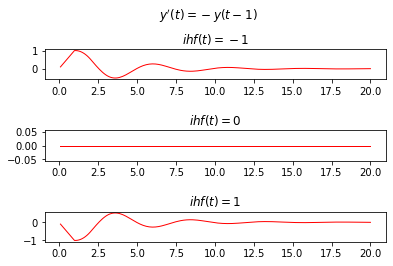

In [9]:
fig, axs = plt.subplots(3, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-1)$")

axs[0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0].set_title('$ihf(t)=-1$')
 
axs[1].plot(case2.ts, case2.x, color='red', linewidth=1)
axs[1].set_title('$ihf(t)=0$')

axs[2].plot(case3.ts, case3.x, color='red', linewidth=1)
axs[2].set_title('$ihf(t)=1$')

plt.show()

#### Example #2: First-order DDE with one constant delay and a non constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t-2)
$$

where the delay is 2 s; the example compares the solutions of four different cases using two different non constant history functions and two different intervals of $t$:

- Case #1: $\phi(t)=e^{-t} - 1, t \in [0, 4]$
- Case #2: $\phi(t)=e^{t} - 1, t \in [0, 4]$
- Case #3: $\phi(t)=e^{-t} - 1, t \in [0, 60]$
- Case #4: $\phi(t)=e^{t} - 1, t \in [0, 60]$

In [10]:
def eq(x, t, xdelay): 
    return -xdelay(t-2)

delay1 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(-t)-1, dt=0.01, interp_method='round')
delay2 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(t)-1, dt=0.01, interp_method='round')
delay3 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(-t)-1, dt=0.01, interp_method='round')
delay4 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(t)-1, dt=0.01, interp_method='round')

In [11]:
case1 = delay_odeint(4., eq, args={'xdelay': delay1}, state_delays={'x': delay1}, dt=0.01)
case2 = delay_odeint(4., eq, args={'xdelay': delay2}, state_delays={'x': delay2}, dt=0.01)
case3 = delay_odeint(60., eq, args={'xdelay': delay3}, state_delays={'x': delay3}, dt=0.01)
case4 = delay_odeint(60., eq, args={'xdelay': delay4}, state_delays={'x': delay4}, dt=0.01)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

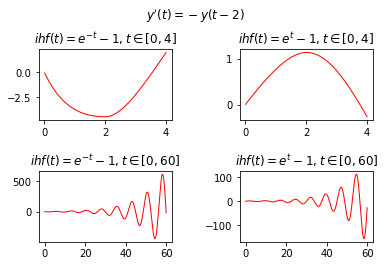

In [12]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-2)$")

axs[0, 0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0, 0].set_title('$ihf(t)=e^{-t} - 1, t \in [0, 4]$')

axs[0, 1].plot(case2.ts, case2.x, color='red', linewidth=1)
axs[0, 1].set_title('$ihf(t)=e^t - 1, t \in [0, 4]$')

axs[1, 0].plot(case3.ts, case3.x, color='red', linewidth=1)
axs[1, 0].set_title('$ihf(t)=e^{-t} - 1, t \in [0, 60]$')

axs[1, 1].plot(case4.ts, case4.x, color='red', linewidth=1)
axs[1, 1].set_title('$ihf(t)=e^t - 1, t \in [0, 60]$')

plt.show()

#### Example #3: First-order DDE with two constant delays and a constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t - 1) + 0.3 y(t - 2)
$$

where the delays are two and are both constants equal to 1s and 2s respectively; The initial historical function is also constant and is $\phi(t)=1$.

In [13]:
def eq(x, t): 
    return -delay(t-1) + 0.3*delay(t-2)

delay = bm.TimeDelay(bm.ones(1), 2., before_t0=1., dt=0.01, interp_method='round')
mon = delay_odeint(10., eq, inits=[1.], state_delays={'x': delay}, dt=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

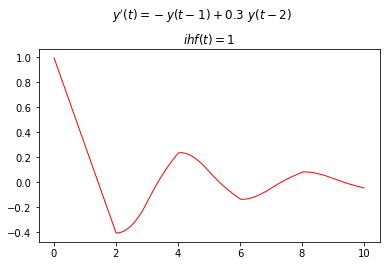

In [14]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-1) + 0.3\ y(t-2)$")

axs.plot(mon.ts, mon.x, color='red', linewidth=1)
axs.set_title('$ihf(t)=1$')

plt.show()

#### Example #4: System of two first-order DDEs with one constant delay and two constant initial history functions

Let the following system of DDEs be given:

$$
\begin{cases}
    y_1'(t) = y_1(t) y_2(t-0.5)
    \\
    y_2'(t) = y_2(t) y_1(t-0.5)
\end{cases}
$$

where the delay is only one, constant and equal to 0.5 s and the initial historical functions are also constant; for what we said at the beginning of the post these must be two, in fact being the order of the system of first degree you need one for each unknown and they are: $y_1(t)=1, y_2(t)=-1$. 

In [15]:
def eq(x, y, t):
    dx = x * ydelay(t-0.5)
    dy = y * xdelay(t-0.5)
    return dx, dy

xdelay = bm.TimeDelay(bm.ones(1), 0.5, before_t0=1., dt=0.01, interp_method='round')
ydelay = bm.TimeDelay(-bm.ones(1), 0.5, before_t0=-1., dt=0.01, interp_method='round')

mon = delay_odeint(3., eq, inits=[1., -1], state_delays={'x': xdelay, 'y': ydelay},
             dt=0.01, monitors=['x', 'y'])

  0%|          | 0/300 [00:00<?, ?it/s]

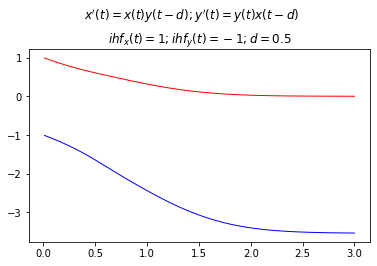

In [16]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$x'(t)=x(t) y(t-d); y'(t)=y(t) x(t-d)$")

axs.plot(mon.ts, mon.x.flatten(), color='red', linewidth=1)
axs.plot(mon.ts, mon.y.flatten(), color='blue', linewidth=1)
axs.set_title('$ihf_x(t)=1; ihf_y(t)=-1; d=0.5$')

plt.show()

#### Example #5: Second-order DDE with one constant delay and two constant initial history functions

Let the following DDE be given:

$$
y(t)'' = -y'(t) - 2y(t) - 0.5 y(t-1)
$$

where the delay is only one, constant and equal to 1 s. Since the DDE is second order, in that the second derivative of the unknown function appears, the historical functions must be two, one to give the values of the unknown $y(t)$ for $t <= 0$,  and one and one to provide the value of the first derivative $y'(t)$ also for $t <= 0$. 

In this example they are the following two constant functions: $y(t)=1, y'(t)=0$.

Due to the properties of the second-order equations, the given DDE is equivalent to the following system of first-order equations:

$$
\begin{cases}
    y_1'(t) = y_2(t)
    \\
    y_2'(t) = -y_1'(t) - 2y_1(t) - 0.5 y_1(t-1)
\end{cases}
$$

and so the implementation falls into the case of the previous example of systems of first-order equations.

In [17]:
def eq(x, y, t):
    dx = y
    dy = -y - 2*x - 0.5*xdelay(t-1)
    return dx, dy

xdelay = bm.TimeDelay(bm.ones(1), 1., before_t0=1., dt=0.01, interp_method='round')
mon = delay_odeint(16., eq, inits=[1., 0.], state_delays={'x': xdelay}, monitors=['x', 'y'], dt=0.01)

  0%|          | 0/1600 [00:00<?, ?it/s]

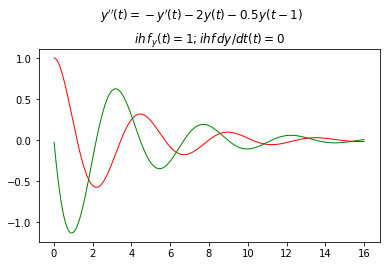

In [18]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y''(t)=-y'(t) - 2 y(t) - 0.5 y(t-1)$")
axs.plot(mon.ts, mon.x[:,0], color='red', linewidth=1)
axs.plot(mon.ts, mon.y[:,0], color='green', linewidth=1)
axs.set_title('$ih \, f_y(t)=1; ihf\,dy/dt(t)=0$')

plt.show()

#### Example #6: First-order DDE with one non constant delay and a constant initial history function

Let the following DDE be given:

$$
y'(t)=y(t-\mathrm{delay}(y, t))
$$

where the delay is not constant and is given by the function $\mathrm{delay}(y, t)=|\frac{1}{10} t y(\frac{1}{10} t)|$, the example compares the solutions of two different cases using two different constant history functions:

- Case #1: $\phi(t)=-1$
- Case #2: $\phi(t)=1$

In [19]:
def eq(x, t, xdelay):
    delay = abs(t*xdelay(t - 0.9 * t)/10) # a tensor with (1,)
    delay = delay[0]
    return xdelay(t-delay)

```{note}

Note here we do not kwon the maximum lenght of the delay. Therefore, we can declare a fixed length delay variable with the ``delay_len`` equal to or even bigger than the running duration. 
```

In [20]:
delay1 = bm.TimeDelay(bm.ones(1), 30., before_t0=-1, dt=0.01)
delay2 = bm.TimeDelay(-bm.ones(1), 30., before_t0=1, dt=0.01)

In [21]:
case1 = delay_odeint(30., eq, args={'xdelay': delay1}, state_delays={'x': delay1}, dt=0.01)
case2 = delay_odeint(30., eq, args={'xdelay': delay2}, state_delays={'x': delay2}, dt=0.01)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

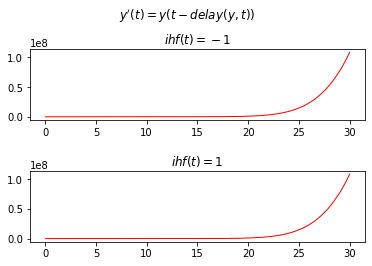

In [22]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=y(t-delay(y, t))$")

axs[0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0].set_title('$ihf(t)=-1$')

axs[1].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[1].set_title('$ihf(t)=1$')

plt.show()

## Delay SDEs

Save as delay ODEs, state-dependent delay variables can be appended into ``state_delay`` argument in ``brainpy.sdeint`` function.

In [23]:
delay = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(-t)-1, dt=0.01, interp_method='round')

f = lambda x, t, xdelay: -xdelay(t-2)
g = lambda x, t, *args: 0.01

dt = 0.01
integral = bp.sdeint(f, g, state_delays={'x': delay})

  0%|          | 0/10000 [00:00<?, ?it/s]

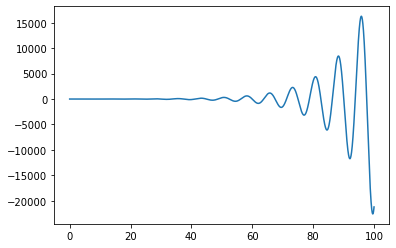

In [24]:
runner= bp.integrators.IntegratorRunner(integral,
                                        monitors=['x'],
                                        args={'xdelay': delay},
                                        dt=dt)
runner.run(100.)

plt.plot(runner.mon.ts, runner.mon.x)
plt.show()

## Delay FDEs

 Fractional order delayed differential equations as the generalization of the delayed differential equations, provide more freedom when we're describing these systems, let's see how we can use BrainPy to accelerate the simulation of fractional order delayed differential equations.

The fractional delayed differential equations has the general form:

$$
\begin{gathered}
D_{t}^{\alpha} y(t)=f(t, y(t), y(t-\tau)), \quad t \geq \xi \\
y(t)=\phi(t), \quad t \in[\xi-\tau, \xi]
\end{gathered}
$$


#### Lemmings' population cycle

The fractional order version of the four-year life cycle of a population of lemmings is given by

$$
\begin{gathered}
D_{t}^{\alpha} y(t)=3.5 y(t)\left(1-\frac{y(t-0.74)}{19}\right), \\
 y(0)=19.00001 \\
y(t)=19, t<0
\end{gathered}
$$

In [25]:
dt=0.05
delay = bm.TimeDelay(bm.asarray([19.00001]), 0.74, before_t0=19., dt=dt)
f = lambda y, t: 3.5 * y * (1 - delay(t-0.74)/19)
integral = bp.fde.GLShortMemory(f, alpha=0.97, inits=[19.00001], num_step=500,
                                state_delays={'y': delay})

  0%|          | 0/2000 [00:00<?, ?it/s]

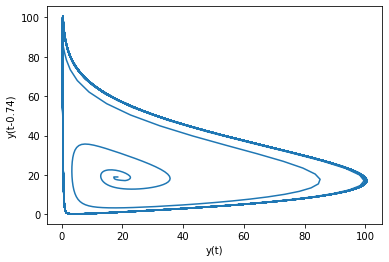

In [26]:
runner = bp.integrators.IntegratorRunner(integral,
                                         inits=bm.asarray([19.00001]),
                                         monitors=['y'],
                                         fun_monitors={'y(t-0.74)': lambda t, _: delay(t-0.74)},
                                         dyn_vars=delay.vars(),
                                         dt=dt)
runner.run(100.)

plt.plot(runner.mon['y'], runner.mon['y(t-0.74)'])
plt.xlabel('y(t)')
plt.ylabel('y(t-0.74)')
plt.show()

#### Time delay Chen system

Time delay Chen system as a famous chaotic system with time delay, has important applications in many fields.

$$
\left\{\begin{array}{l}
D^{\alpha_{1}} x=a(y(t)-x(t-\tau)) \\
D^{\alpha_{2}} y=(c-a) x(t-\tau)-x(t) z(t)+c y(t) \\
D^{\alpha_{3}} z=x(t) y(t)-b z(t-\tau)
\end{array}\right.
$$

In [27]:
dt = 0.001
tau = 0.009
xdelay = bm.TimeDelay(bm.asarray([0.2]), tau, dt=dt)
zdelay = bm.TimeDelay(bm.asarray([0.5]), tau, dt=dt)

def derivative(x, y, z, t):
    a=35; b=3; c=27
    dx = a*(y-xdelay(t-tau))
    dy = (c-a)*xdelay(t-tau)-x*z+c*y
    dz = x*y-b*zdelay(t-tau)
    return dx, dy, dz

integral = bp.fde.GLShortMemory(derivative,
                                alpha=0.94,
                                inits=[0.2, 0., 0.5],
                                num_step=500,
                                state_delays={'x': xdelay, 'z': zdelay})

In [28]:
runner = bp.integrators.IntegratorRunner(integral,
                                         inits=[0.2, 0., 0.5],
                                         monitors=['x', 'y', 'z'],
                                         dyn_vars=xdelay.vars() + zdelay.vars(),
                                         dt=dt)
runner.run(100.)

  0%|          | 0/100000 [00:00<?, ?it/s]

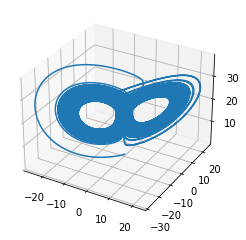

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.plot(runner.mon.x[:, 0], runner.mon.y[:, 0], runner.mon.z[:, 0])
plt.show()

#### Enzyme kinetics

Let's see a more complex example of the fractional order version of enzyme kinetics with an inhibitor molecule:

$$
\begin{gathered}
D_{t}^{\alpha} y_{1}(t)=10.5-\frac{y_{1}(t)}{1+0.0005 y_{4}^{3}(t-4)} \\
D_{t}^{\alpha} y_{2}(t)=\frac{y_{1}(t)}{1+0.0005 y_{4}^{3}(t-4)}-y_{2}(t) \\
D_{t}^{\alpha} y_{3}(t)=y_{2}(t)-y_{3}(t) \\
D_{t}^{\alpha} y_{4}(t)=y_{3}(t)-0.5 y_{4}(t) \\
y(t)=[60,10,10,20], t \leq 0
\end{gathered}
$$

In [30]:
dt = 0.01
tau = 4.
delay = bm.TimeDelay(bm.asarray([20.]), tau, before_t0=20, dt=dt)

def derivative(a, b, c, d, t):
    da = 10.5-a/(1+ 0.0005 * delay(t-tau)**3)
    db = a/(1+0.0005 * delay(t-tau)**3)-b
    dc = b-c
    dd = c-0.5*d
    return da, db, dc, dd

integral = bp.fde.GLShortMemory(derivative,
                                alpha=0.95,
                                inits=[60, 10, 10, 20],
                                num_step=500,
                                state_delays={'d': delay})

In [31]:
runner = bp.integrators.IntegratorRunner(integral,
                                         inits=[60, 10, 10, 20],
                                         monitors=list('abcd'),
                                         dyn_vars=delay.vars(),
                                         dt=dt)
runner.run(200.)

  0%|          | 0/20000 [00:00<?, ?it/s]

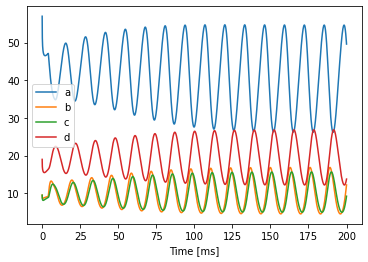

In [32]:
plt.plot(runner.mon.ts, runner.mon.a, label='a')
plt.plot(runner.mon.ts, runner.mon.b, label='b')
plt.plot(runner.mon.ts, runner.mon.c, label='c')
plt.plot(runner.mon.ts, runner.mon.d, label='d')
plt.legend()
plt.xlabel('Time [ms]')
plt.show()

#### Fractional matrix delayed differential equations

BrainPy is also capable of solving fractional matrix delayed differential equations:

$$
D_{t_{0}}^{\alpha} \mathbf{x}(t)=\mathbf{A}(t) \mathbf{x}(t)+\mathbf{B}(t) \mathbf{x}(t-\tau)+\mathbf{c}(t)
$$

Here $x(t)$ is vector of states of the system, $c(t)$ is a known function of disturbance.

We explain the detailed usage by using an example:

$$
\mathbf{x}(t)=\left(\begin{array}{l}
x_{1}(t) \\
x_{2}(t) \\
x_{3}(t) \\
x_{4}(t)
\end{array}\right)
$$

$$
\mathbf{A}=\left(\begin{array}{cccc}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & -2 & 0 & 0 \\
-2 & 0 & 0 & 0
\end{array}\right)
$$

$$
\mathbf{B}=\left(\begin{array}{cccc}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
-2 & 0 & 0 & 0 \\
0 & -2 & 0 & 0
\end{array}\right)
$$

With initial condition:

$$
\mathbf{x}_{0}(t)=\left(\begin{array}{c}
\sin (t) \cos (t) \\
\sin (t) \cos (t) \\
\cos ^{2}(t)-\sin ^{2}(t) \\
\cos ^{2}(t)-\sin ^{2}(t)
\end{array}\right)
$$

In [33]:
dt = 0.01
tau = 3.1416
f = lambda t: bm.asarray([bm.sin(t)*bm.cos(t),
                          bm.sin(t)*bm.cos(t),
                          bm.cos(t)**2-bm.sin(t)**2,
                          bm.cos(t)**2-bm.sin(t)**2])
delay = bm.TimeDelay(f(0.), tau, before_t0=f, dt=dt)

A = bm.asarray([[0, 0, 1, 0], [0, 0, 0, 1], [0, -2, 0, 0], [-2, 0, 0, 0]])
B = bm.asarray([[0, 0, 0, 0], [0, 0, 0, 0], [-2, 0, 0, 0], [0, -2, 0, 0]])
c = bm.asarray([0, 0, 0, 0])
derivative = lambda x, t: A @ x + B @ delay(t - tau) + c

integral = bp.fde.GLShortMemory(derivative,
                                alpha=0.4,
                                inits=[f(0.)],
                                num_step=500,
                                state_delays={'x': delay})

In [34]:
runner = bp.integrators.IntegratorRunner(integral,
                                         inits=[f(0.)],
                                         monitors=['x'],
                                         dyn_vars=delay.vars(),
                                         dt=dt)
runner.run(100.)

  0%|          | 0/10000 [00:00<?, ?it/s]

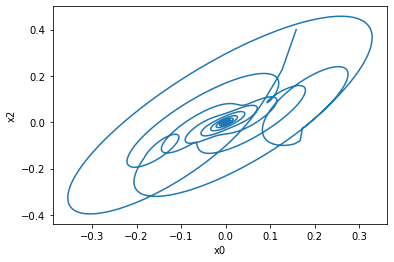

In [35]:
plt.plot(runner.mon.x[:, 0], runner.mon.x[:, 2])
plt.xlabel('x0')
plt.ylabel('x2')
plt.show()

## Acknowledgement

This tutorial is highly inspired from the work of Ettore Messina [1] and of Qingyu Qu [2].

- [1] Computational Mindset by Ettore Messina, [Solving delay differential equations using numerical methods in Python](https://computationalmindset.com/en/mathematics/solving-delay-differential-equations-in-python-using-numerical-methods.html)
- [2] [Fractional Order Delayed Differential Equations](https://scifracx.org/FractionalDiffEq.jl/dev/fdde/)